### 0. 코랩 구동을 위한 설정

###### 0.1 구글드라이브와 연동

In [1]:
from google.colab import drive
drive.mount('/content/workingdrive')

Drive already mounted at /content/workingdrive; to attempt to forcibly remount, call drive.mount("/content/workingdrive", force_remount=True).


###### 0.2 모듈 설치

In [2]:
!pip install konlpy
!pip install pyLDAvis

###### 0.3 모듈 불러오기

In [3]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import logging
import time
import datetime

from gensim.models import word2vec
from konlpy.tag import Okt
%matplotlib inline

from string import punctuation
from collections import Counter

import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
import collections

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
pip install -U gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.8.3)


#### 0.4 맷플롯립을 위한 폰트 설정

In [5]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [6]:
plt.rc('font', family='NanumBarunGothic') 

### 1. 데이터 로드 및 확인

In [139]:
bill_df = pd.read_csv('/content/workingdrive/My Drive/Colab Notebooks/data/bill_total.csv')
print(bill_df.shape)
bill_df.head()

(25908, 41)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,의안번호,처리여부,의안명,제안자구분,제안일자,의결일자,의결결과,심사진행상태,문서,제안회기,제안이유,소관위원회,제안자,제안정당,법률안,법률공포여부,개혁보수신당,국민의당,기본소득당,대안신당,대한애국당,더불어민주당,더불어시민당,무소속,미래를향한전진4.0,미래통합당,미래한국당,민생당,민주평화당,민중당,바른미래당,바른정당,새누리당,새로운보수당,새민중정당,시대전환,열린민주당,우리공화당,자유한국당,정의당,의안명+제안이유
0,2024996,처,집합건물의 소유 및 관리에 관한 법률 일부개정법률안,의원,2020-05-22,2020-05-29,임기만료폐기,NaN,의안원문,제20대 (2016~2020) 제378회,아파트 등 공동주택은 공동주택관리법 에 의해 체계적으로 관리되고 있는 반면 주상...,법제사법위원회,"[""['김병관(더불어민주당/金炳官)'"", "" '고용진(더불어민주당/高榕禛)'"", ""...",['더불어민주당'],1.0,미공포,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,집합건물의 소유 및 관리에 관한 법률 일부개정법률안 아파트 등 공동주택은 공동주택...
1,2024995,처,지방세법 일부개정법률안,의원,2020-05-22,2020-05-29,임기만료폐기,NaN,의안원문\r\n비용추계서 미첨부 사유서,제20대 (2016~2020) 제378회,법상 아파트 등 주택에 대한 재산세 과세표준은 국토교통부가 해마다 부동산 가격공시...,행정안전위원회,"[""['김병관(더불어민주당/金炳官)'"", "" '김철민(더불어민주당/金哲玟)'"", ""...",['더불어민주당'],1.0,미공포,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,지방세법 일부개정법률안 법상 아파트 등 주택에 대한 재산세 과세표준은 국토교통부가 ...
2,2024994,처,법률용어 정비를 위한 정보위원회 소관 개 법률 일부개정을 위한 법률안,위원장,2020-05-20,2020-05-20,원안가결,NaN,의안원문,제20대 (2016~2020) 제378회,NaN,정보위원회,"[""['김민기(더불어민주당/金敏基)']""]",['더불어민주당'],1.0,공포,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,법률용어 정비를 위한 정보위원회 소관 개 법률 일부개정을 위한 법률안
3,2024993,처,진실 화해를 위한 과거사정리 기본법 일부개정법률안,위원장,2020-05-20,2020-05-20,원안가결,NaN,의안원문,제20대 (2016~2020) 제378회,NaN,행정안전위원회,"[""['전혜숙(더불어민주당/全惠淑)']""]",['더불어민주당'],1.0,공포,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,진실 화해를 위한 과거사정리 기본법 일부개정법률안
4,2024992,처,화재예방 소방시설 설치 유지 및 안전관리에 관한 법률 일부개정법률안,위원장,2020-05-20,2020-05-20,원안가결,NaN,의안원문,제20대 (2016~2020) 제378회,NaN,행정안전위원회,"[""['전혜숙(더불어민주당/全惠淑)']""]",['더불어민주당'],1.0,공포,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,화재예방 소방시설 설치 유지 및 안전관리에 관한 법률 일부개정법률안


In [140]:
bill_df.columns

Index(['의안번호', '처리여부', '의안명', '제안자구분', '제안일자', '의결일자', '의결결과', '심사진행상태', '문서',
       '제안회기', '제안이유', '소관위원회', '제안자', '제안정당', '법률안', '법률공포여부', '개혁보수신당',
       '국민의당', '기본소득당', '대안신당', '대한애국당', '더불어민주당', '더불어시민당', '무소속',
       '미래를향한전진4.0', '미래통합당', '미래한국당', '민생당', '민주평화당', '민중당', '바른미래당', '바른정당',
       '새누리당', '새로운보수당', '새민중정당', '시대전환', '열린민주당', '우리공화당', '자유한국당', '정의당',
       '의안명+제안이유'],
      dtype='object')

In [141]:
## 분석의 편의를 위해 분석일자, 의결일자를 연-월 로 변경
time_list = []
for i in bill_df['제안일자']:
  time = i.split('-')[0] + '-' + i.split('-')[1]
  time_list.append(time)

bill_df['제안일자(Y-M)'] = time_list

In [197]:
## 의결 처리기간 칼럼 추가

bill_df['제안일자'] = pd.to_datetime(bill_df['제안일자'])
bill_df['의결일자'] = pd.to_datetime(bill_df['의결일자'])

bill_df['의결처리기간'] = (bill_df['의결일자'] - bill_df['제안일자']).dt.days

In [173]:
bill_df.loc[bill_df['의결결과'].isnull() == True, '의결결과'] = '계류'

In [143]:
bill_df.columns
bill_df.drop(['처리여부', '심사진행상태', '문서', '제안자', '법률안'], axis=1, inplace=True)

## 2. 최저임금 관련 키워드 뽑아내기

>1) 법안에서 '최저임금'이라는 단어 의안명+제안이유에 들어간 법안 뽑아내기  
2) word2vec을 이용하여 '최저임금'과 유사성이 높은 단어 뽑아내기  
3) '최저임금'과 유사성이 높은 단어가 의안명+제안이유 들어간 법안 뽑아내기 

#### 2.1  법안에서 '최저임금'이라는 단어 의안명+제안이유에 들어간 법안 뽑아내기

In [199]:
keyword = r'.*(최저 임금|최저임금).*'
min_rage = bill_df[bill_df['의안명'].str.match(keyword) | bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]
print(min_rage.shape)

(231, 38)


#### 2.2 word2vec을 이용하여 '최저임금'과 유사성이 높은 단어 뽑아내기

In [200]:
# 한글 전처리
def preprocessing(text): 
  text = re.sub('\\\\n', ' ', text)
  text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
  return text

# 의미없는 단어 삭제 
def remove_stopword(text): 
    stopwords = ['사이','을','이','의','를','에','가','들','은','는','으로','한','도',
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는',
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지',
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근',
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄'
              '중','게','너무','자','이런','때','되지','위해','에는','없는',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',
             '마련','있도록','또는','함','하도록','개월','부터','제호','관','되고','년','월','및','등','안','바','이','것','부터','수','시','자']

    text = [word for word in text if word not in stopwords]
    return text

In [13]:
%time contents = bill_df['의안명+제안이유'].apply(preprocessing)

CPU times: user 886 ms, sys: 242 µs, total: 886 ms
Wall time: 886 ms


In [14]:
# 단어에서 명사만 뽑아내기
okt = Okt()
%time tokens = contents.apply(okt.nouns)
tokens[:3]

CPU times: user 11min 56s, sys: 1.52 s, total: 11min 57s
Wall time: 11min 44s


0    [집합, 건물, 소유, 및, 관리, 관, 법률, 일부, 개정, 법률, 안, 아파트,...
1    [지방, 세법, 일부, 개정, 법률, 안, 법, 아파트, 등, 주택, 대한, 재산세...
2    [법률용어, 정비, 위, 정보, 위원회, 소관, 개, 법률, 일부, 개정, 위, 법...
Name: 의안명+제안이유, dtype: object

In [15]:
# 명사들 중 불용어 제거
tokens_clean = tokens.apply(remove_stopword)

In [16]:
# word2vec 모델 학습에 로그를 찍을 수 있도록 합니다.

logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [17]:
# 모델 학습
model = word2vec.Word2Vec(tokens_clean, size=100, window=2, workers=4, min_count=2, iter=30, sg=1)

model

2020-08-31 10:48:49,944 : INFO : collecting all words and their counts
2020-08-31 10:48:49,946 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-08-31 10:48:50,181 : INFO : PROGRESS: at sentence #10000, processed 1089995 words, keeping 14511 word types
2020-08-31 10:48:50,435 : INFO : PROGRESS: at sentence #20000, processed 2202550 words, keeping 18457 word types
2020-08-31 10:48:50,589 : INFO : collected 19696 word types from a corpus of 2872994 raw words and 25908 sentences
2020-08-31 10:48:50,590 : INFO : Loading a fresh vocabulary
2020-08-31 10:48:50,646 : INFO : effective_min_count=2 retains 15643 unique words (79% of original 19696, drops 4053)
2020-08-31 10:48:50,647 : INFO : effective_min_count=2 leaves 2868941 word corpus (99% of original 2872994, drops 4053)
2020-08-31 10:48:50,699 : INFO : deleting the raw counts dictionary of 19696 items
2020-08-31 10:48:50,700 : INFO : sample=0.001 downsamples 37 most-common words
2020-08-31 10:48:50,701 : INF

In [18]:
# 모델 이름을 지정하고 저장한다.
model_name = '1minwords'
model.save(model_name)

2020-08-31 10:52:48,322 : INFO : saving Word2Vec object under 1minwords, separately None
2020-08-31 10:52:48,326 : INFO : not storing attribute vectors_norm
2020-08-31 10:52:48,328 : INFO : not storing attribute cum_table
2020-08-31 10:52:48,511 : INFO : saved 1minwords


In [19]:
len(model.wv.vocab)

15643

In [20]:
vocab = model.wv.vocab

In [118]:
## '최저임금', '임금'과 같이 쓰이는 단어 목롬
print(model.wv.most_similar('최저임금'))
print(model.wv.most_similar('임금'))

[('최저임금법', 0.7246941924095154), ('임금', 0.6600346565246582), ('주급', 0.6451418399810791), ('생활임금', 0.5881861448287964), ('고용노동부', 0.5814893245697021), ('답습', 0.5781465172767639), ('일급', 0.5778284072875977), ('주휴수당', 0.575836718082428), ('가계비', 0.5586928129196167), ('상률', 0.556227445602417)]
[('체불', 0.7692755460739136), ('주휴수당', 0.6675313115119934), ('최저임금', 0.6600346565246582), ('주급', 0.6548869609832764), ('임금노동', 0.6475584506988525), ('직상', 0.6442273855209351), ('체불액', 0.6308268308639526), ('근로자', 0.6276575326919556), ('동무', 0.627482533454895), ('불로', 0.6243318319320679)]


키워드 __'최저임금'__으로만 토픽모델링을 진행해도 되지만 __최저임금과 관련된 추가적인 키워드__로 진행해도 더 많은 인사이트를 얻을 수 있을 것이라 기대.

1) 최초에는 '최저임금' 키워드로 토픽모델링  
2) 최저임금과 유사도가 높은 키워드 중 '최저임금법', '임금', '일급', '시급', '주휴수당'을 키워드로 선정하여 토픽모델링 진행

#### 2.3 '최저임금'과 유사성이 높은 단어가 의안명+제안이유 들어간 법안 뽑아내기  

- word2vec을 통해 뽑아낸 '최저임금법', '임금', '일급', '시급'을 추가

In [201]:
keyword = r'.*(최저임금|임금|일급|주휴수당).*'
rage = bill_df[bill_df['의안명'].str.match(keyword) | bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]
print(rage.shape)

(657, 38)


## 3. 키워드 '최저임금' 분석

#### 3.1 법안은 언제 발의됐는가

In [174]:
rage_proposer_date = pd.DataFrame(min_rage.groupby('제안일자(Y-M)')['의안명'].count())
rage_proposer_date.head()

,의안명
제안일자(Y-M),
2016-06,6
2016-07,13
2016-08,13
2016-09,1
2016-10,4


Text(0.5, 1.0, '월별 최저임금 관련 법안 발의 건수')

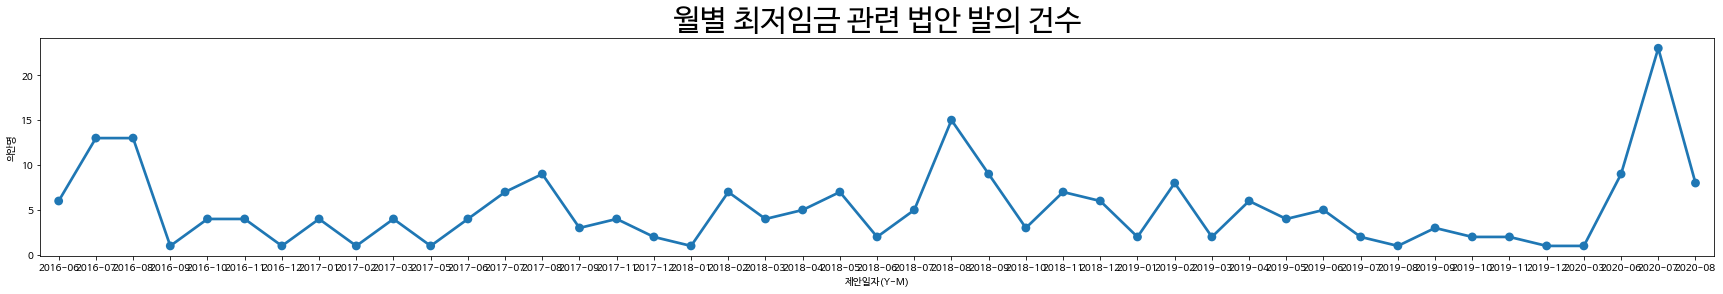

In [175]:
plt.figure(figsize = (30,4))
sns.pointplot(data = rage_proposer_date, x=rage_proposer_date.index, y='의안명')
plt.title('월별 최저임금 관련 법안 발의 건수', fontsize=30)

매 년 6~8월에 의안이 집중되는 경향이 있음 -> 혹시 최저임금 관련 법안이 아니더라도 법안 발의가 여름에 몰리는 것 아닐까?

Text(0.5, 1.0, '월별 법안 발의 건수')

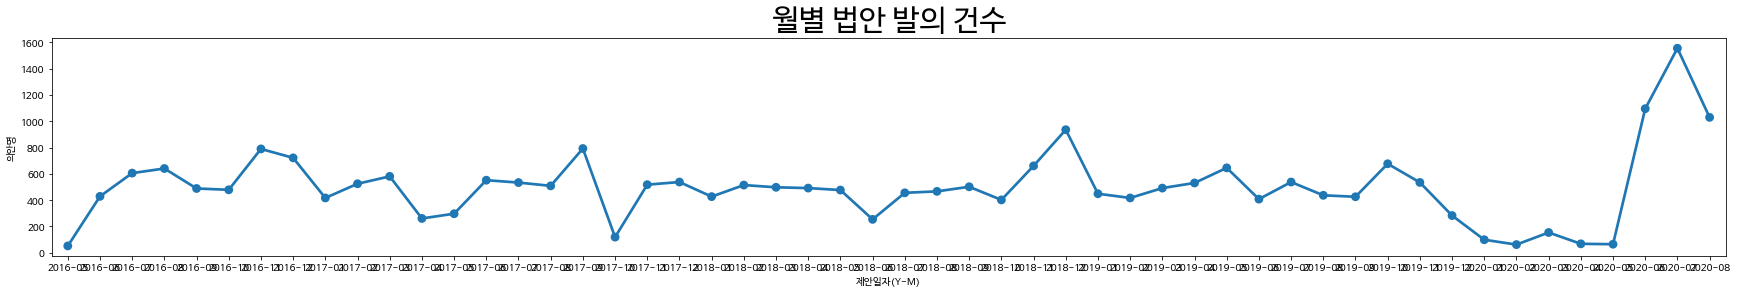

In [111]:
plt.figure(figsize = (30,4))

proposer_date = pd.DataFrame(bill_df.groupby('제안일자(Y-M)')['의안명'].count())
sns.pointplot(data = proposer_date, x=proposer_date.index, y='의안명')
plt.title('월별 법안 발의 건수', fontsize=30)

월별 법안발의 건수와 대동소이하나 __여름에 좀 더 집중__되는 경향이 보임  

최저임금은 매년 __8월 5일__ 최저임금위원회와 고용노동부에 의해 고시.  
최저임금과 관련된 특별한 사건에 의해 법안이 발의된다기 보다는 __최저임금이 결정되는 시기__를 전후로 법안을 발의하는 것으로 보임


#### 3.2 법안 공포여부

In [202]:
min_rage['의결결과'].value_counts()

임기만료폐기    153
계류         40
대안반영폐기     30
수정가결        3
원안가결        3
철회          2
Name: 의결결과, dtype: int64

In [204]:
min_rage['의결처리기간']
pd.pivot_table(min_rage, index = ['법률공포여부', '의결결과'], values = ['의결처리기간'])

의결처리기간
법률공포여부 의결결과              
공포     수정가결    173.333333
       원안가결      0.333333
미공포    대안반영폐기  323.233333
       임기만료폐기  819.392157
       철회       25.000000

의미있는 분석을 하기엔 공포된 법안의 수가 6개로 매우적음.  
원안가결 3개의 평균 처리기간이 0.3일로 매우 짧은 이유는?

In [222]:
min_rage.columns

Index(['의안번호', '의안명', '제안자구분', '제안일자', '의결일자', '의결결과', '제안회기', '제안이유', '소관위원회',
       '제안정당', '법률공포여부', '개혁보수신당', '국민의당', '기본소득당', '대안신당', '대한애국당', '더불어민주당',
       '더불어시민당', '무소속', '미래를향한전진4.0', '미래통합당', '미래한국당', '민생당', '민주평화당', '민중당',
       '바른미래당', '바른정당', '새누리당', '새로운보수당', '새민중정당', '시대전환', '열린민주당', '우리공화당',
       '자유한국당', '정의당', '의안명+제안이유', '제안일자(Y-M)', '의결처리기간'],
      dtype='object')

In [233]:
proposer_party = min_rage[['개혁보수신당', '국민의당', '기본소득당', '대안신당', '대한애국당', '더불어민주당',
                            '더불어시민당', '무소속', '미래를향한전진4.0', '미래통합당', '미래한국당', '민생당', '민주평화당', '민중당',
                            '바른미래당', '바른정당', '새누리당', '새로운보수당', '새민중정당', '시대전환', '열린민주당', '우리공화당',
                            '자유한국당', '정의당']]

pd.DataFrame(proposer_party.sum(), columns = ['법안발의 수']).sort_values('법안발의 수', ascending = False).T

,더불어민주당,자유한국당,무소속,국민의당,바른미래당,미래통합당,정의당,민주평화당,바른정당,새누리당,미래한국당,미래를향한전진4.0,더불어시민당,민생당,대한애국당,민중당,대안신당,새로운보수당,새민중정당,시대전환,열린민주당,우리공화당,기본소득당,개혁보수신당
법안발의 수,126.0,71.0,50.0,47.0,34.0,27.0,25.0,18.0,7.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 3.2 법안 토픽모델링

In [26]:
stopword = pd.read_csv('/content/workingdrive/My Drive/Colab Notebooks/data/한국어불용어100.txt', sep = "\t")
stopword_list = list(stopword['이'])

In [27]:
###################### 텍스트전처리 ######################

def Preproc(textlist):

  ## 특수문자 제거 & 명사추출
  okt = Okt()
  cleanlist = []
  nounlist = []
  removedict = ['법률','법률안','사업','지원','위원회', '관리','국가','해당','발생','관련','사항','있음', '제조', '제항', '경우', '대한', \
                '일부', '개정', '것임','현행법','조의','국회법','조제', '내용', '행위', '운영', '업무','이상', '신설', '규정',\
                '기준', '마련', '설치', '대상', '또는', '대해', '대하', '거나', '개정', \
                '최저임금', '코로나', '함안', '개정', '근로자', '임금', '최저임금법']
        
  for i in range(len(textlist)):
    n = re.sub('[-=.#/:$}·,■?]','',str(textlist[i]))
    k = re.sub('[0-9]','',n)
    nounlist.append(okt.nouns(k))
    
  for i in nounlist:
    for j in i:
      if len(j)==1:
        i.remove(j)
  for i in nounlist:
    for j in i:
      if j in removedict:
        i.remove(j)
  for i in nounlist:
    for j in i:
      if j in stopword_list:
        i.remove(j)

  cleanlist = nounlist
    
  return cleanlist

###################### 상위 50개 단어 제거 ######################


def remove_common(cleanlist):
  collections.Counter()

  flat=[]
  for i in cleanlist:
    for j in i:
      if (j not in stopword_list) or (len(j)!=1):
        flat.append(j)
                    
                    
  commoncount = collections.Counter(flat)
  commoncount = commoncount.most_common(50)

  newdict = []

  for i in range(len(commoncount)): #50
    newdict.append(commoncount[i][0])

  for i in cleanlist:
    if i in newdict:
      cleanlist.remove(i)
    
  return cleanlist, newdict

###################### 말뭉치 ######################

def make_corpus(cleanlist):

  dictionary = corpora.Dictionary(cleanlist)
  corpus = [dictionary.doc2bow(text) for text in cleanlist]
    
  return corpus, dictionary, cleanlist

###################### 토픽수최적화 ######################

def coh_visual(corpus, dictionary, cleanlist):
    
  coherence_values = []
    
  for i in range(2,20):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word = dictionary)
    coherence_model_lda = CoherenceModel(model = ldamodel, texts = cleanlist, dictionary = dictionary, topn=10)
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)
    
  x = range(2,20)
  plt.plot(x, coherence_values)
  plt.xlabel('number of topics')
  plt.ylabel('coherence score')
  plt.show()
      
###################### 언어모델평가 ######################

def perp_visual(corpus, dictionary):
    
  perplexity_values = []
    
  for i in range(2,20):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word = dictionary)
    perplexity_values.append(ldamodel.log_perplexity(corpus))
    
  x = range(2,20)
  plt.plot(x, perplexity_values)
  plt.xlabel('number of topics')
  plt.ylabel('perplexity score')
  plt.show()

In [28]:
### 각 문장에서 지배적인 토픽을 찾는 함수

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)

    return sent_topics_df

In [29]:
## 각 토픽별 가장 대표적인 토픽 찾기

def find_typical_topic(ldamodel, corpus, text):
  # Group top 5 sentences under each topic
  sent_topics_sorteddf_mallet = pd.DataFrame()

  df_topic_sents_keywords = format_topics_sentences(ldamodel, corpus, text)

  sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

  for i, grp in sent_topics_outdf_grpd:
      sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                              grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                              axis=0)

  # Reset Index    
  sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
  sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

  return sent_topics_sorteddf_mallet

In [30]:
## 최저임금 법안을 하나의 리스트로 만들기
min_rage_text_list = []
for i in min_rage['의안명+제안이유']:
  min_rage_text_list.append(i)

2020-08-31 10:53:54,737 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-08-31 10:53:54,761 : INFO : built Dictionary(2332 unique tokens: ['가중', '간이', '개인', '개정', '경감']...) from 231 documents (total 22594 corpus positions)
2020-08-31 10:53:54,782 : INFO : using symmetric alpha at 0.5
2020-08-31 10:53:54,783 : INFO : using symmetric eta at 0.5
2020-08-31 10:53:54,789 : INFO : using serial LDA version on this node
2020-08-31 10:53:54,791 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 231 documents, updating model once every 231 documents, evaluating perplexity every 231 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 10:53:54,792 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 10:53:55,080 : INFO : -8.201 per-word bound, 294.2 perplexity estimate based on a held-out corpus of 231 documents with 

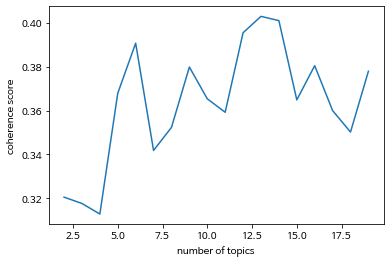

In [31]:
min_rage_clean = Preproc(min_rage_text_list)
min_rage_corpus, min_rage_dictionary, min_rage_cleanlist = make_corpus(min_rage_clean)
coh_visual(min_rage_corpus, min_rage_dictionary, min_rage_cleanlist)

2020-08-31 10:54:13,475 : INFO : using symmetric alpha at 0.5
2020-08-31 10:54:13,477 : INFO : using symmetric eta at 0.5
2020-08-31 10:54:13,480 : INFO : using serial LDA version on this node
2020-08-31 10:54:13,483 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 231 documents, updating model once every 231 documents, evaluating perplexity every 231 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 10:54:13,485 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 10:54:13,790 : INFO : -8.207 per-word bound, 295.6 perplexity estimate based on a held-out corpus of 231 documents with 22594 words
2020-08-31 10:54:13,791 : INFO : PROGRESS: pass 0, at document #231/231
2020-08-31 10:54:14,019 : INFO : topic #0 (0.500): 0.013*"위원" + 0.011*"고용" + 0.010*"결정" + 0.010*"지급" + 0.009*"적용" + 0.008*"급여" + 0.008*"법률" + 0.008*"최저임금" + 0

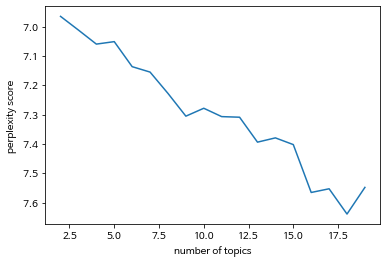

In [32]:
perp_visual(min_rage_corpus, min_rage_dictionary)

coherence score는 높을수록, perplexity score는 낮을수록 모델의 개수가 최적이라는 뜻 -> 군집의 개수 = 12

In [33]:
ldamodel = gensim.models.ldamodel.LdaModel(min_rage_corpus, num_topics=15, alpha=0.1, id2word = min_rage_dictionary)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, min_rage_corpus, min_rage_dictionary)
vis

2020-08-31 10:54:29,083 : INFO : using symmetric eta at 0.06666666666666667
2020-08-31 10:54:29,085 : INFO : using serial LDA version on this node
2020-08-31 10:54:29,094 : INFO : running online (single-pass) LDA training, 15 topics, 1 passes over the supplied corpus of 231 documents, updating model once every 231 documents, evaluating perplexity every 231 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 10:54:29,096 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 10:54:29,411 : INFO : -10.620 per-word bound, 1573.3 perplexity estimate based on a held-out corpus of 231 documents with 22594 words
2020-08-31 10:54:29,412 : INFO : PROGRESS: pass 0, at document #231/231
2020-08-31 10:54:29,649 : INFO : topic #13 (0.100): 0.021*"장애인" + 0.017*"급여" + 0.013*"고용" + 0.012*"지급" + 0.010*"구직" + 0.010*"활동" + 0.010*"세율" + 0.009*"법인" + 0.009*"제조" + 0.008*"기업"
2020-08-31 10:54:29,

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.080309  0.061592       1        1  11.787505
11     0.062442  0.048626       2        1  10.872846
4      0.068214  0.021057       3        1   8.539803
13    -0.057716  0.029501       4        1   8.447024
5      0.034581  0.014977       5        1   8.125595
0     -0.085570  0.066724       6        1   7.334803
12     0.017479  0.056960       7        1   7.252776
9     -0.027321 -0.014312       8        1   7.226233
1      0.072347 -0.009281       9        1   6.866250
2      0.001989 -0.017230      10        1   6.590584
7      0.058352 -0.009534      11        1   4.232707
8     -0.028112 -0.120959      12        1   3.360646
3      0.039223 -0.014158      13        1   3.281464
10    -0.032132 -0.048976      14        1   3.262425
6     -0.043466 -0.064986      15        1   2.819328, topic_info=     Term        Freq       Total Category  logprob  loglift
971    계약   82.000000   82.000000  Default  30.0000  30.0000
154    위원  193.000000  193.000000  Default  29.0000  29.0000
230    급여  163.000000  163.000000  Default  28.0000  28.0000
303   장애인  174.000000  174.000000  Default  27.0000  27.0000
106    활동  153.000000  153.000000  Default  26.0000  26.0000
..    ...         ...         ...      ...      ...      ...
346    결정    3.490011  171.664520  Topic15  -5.2069  -0.3270
232    보험    2.762359   66.360039  Topic15  -5.4407   0.3897
334    정부    2.844128   80.648544  Topic15  -5.4115   0.2238
100  최저임금    3.069185  173.521225  Topic15  -5.3354  -0.4662
52     제도    2.873718  104.360352  Topic15  -5.4012  -0.0236

[1065 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1339     10  0.350506   가격
1339     12  0.087626   가격
1339     13  0.087626   가격
1339     15  0.087626   가격
1602      5  0.350587  가까이
...     ...       ...  ...
1574     15  0.048391   훈련
1732      5  0.420622   휴게
1733      5  0.422921   휴식
1967      3  0.632978   희생
1967     11  0.316489   희생

[3467 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 12, 5, 14, 6, 1, 13, 10, 2, 3, 8, 9, 4, 11, 7])

In [34]:
find_typical_topic(ldamodel, min_rage_corpus, min_rage_cleanlist)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9904,"부담, 적용, 공제, 사업자, 과세, 인상, 개정, 금액, 세액, 중소기업","[특례, 개정, 법, 중소기업, 중견, 기업, 당시, 고용, 비정규직, 정규직, 전..."
1,1.0,0.9908,"위원, 지급, 위원회, 공익, 법률, 사용자, 인상, 일부, 제조, 결정","[공직선거법, 개정, 현행법, 후보자, 예비, 후보자, 선거운동, 선거, 사무장, ..."
2,2.0,0.9866,"근로, 지급, 고용, 하도급, 수급, 최저임금, 사업자, 보험, 조정, 부담","[하도급, 거래, 정화, 일부, 업자, 로부터, 위탁, 수급, 사업자, 노무, 납품..."
3,3.0,0.9948,"급여, 육아휴직, 지급, 소득, 만원, 기간, 보험, 평균, 결정, 위원","[고용, 보험, 의, 대안, 현행, 실업, 급여, 지급, 수준, 실업, 급여, 지급..."
4,4.0,0.9902,"근로, 위원, 최저임금, 법률, 적용, 결정, 고용, 서비스, 심의, 사용자","[서비스, 이용, 이용권, 개정, 법률, 서비스, 종사, 국민, 서비스, 직접, 수..."
5,5.0,0.9898,"고용, 결정, 소득, 근로, 위원, 적용, 제조, 최저임금, 법률, 노동","[국회의원, 수당, 관, 일부, 현재, 국회의원, 연간, 지급, 세비, 일반, 수당..."
6,6.0,0.9779,"계약, 고용, 근로, 조건, 기업, 인상, 세율, 소득, 청년, 지방자치단체","[지방자치단체, 당사자, 계약, 법률, 활, 최소한, 인간, 문화, 생활, 목적, ..."
7,7.0,0.9801,"위원, 지급, 법률, 일부, 사용자, 임안, 최저임금, 금액, 계약, 공익","[참전, 유공, 및, 단체, 설립, 일부, 법률, 명예, 수당, 위해, 목숨, 참전..."
8,8.0,0.9872,"계약, 조건, 근로, 장애인, 고용, 근로시간, 시설, 일부, 부담, 상대자","[지방자치단체, 당사자, 계약, 일부, 법률, 구의역, 열차, 진입, 여부, 확인,..."
9,9.0,0.9926,"장애인, 고용, 법률, 적용, 임안, 일부, 지급, 외국인, 보육, 기업","[장애인, 고용, 촉진, 직업, 재활, 개정, 현재, 장애, 인복, 지법, 보호, ..."


?????

#### 3.3 정당별 토픽모델링

In [35]:
cond1 = min_rage['더불어민주당'] == 1
cond2 = min_rage['더불어시민당'] == 1

cond3 = min_rage['새누리당'] == 1
cond4 = min_rage['자유한국당'] == 1
cond5 = min_rage['미래통합당'] == 1
cond6 = min_rage['미래한국당'] == 1

cond7 = min_rage['정의당'] == 1

cond8 = min_rage['국민의당'] == 1

minzu = min_rage[cond1 | cond2]
mirae = min_rage[cond3 | cond4 | cond5 | cond6]
jeongwui = min_rage[cond7]
gookmin = min_rage[cond8]

print(minzu.shape)
print(mirae.shape)
print(jeongwui.shape)
print(gookmin.shape)

(126, 34)
(102, 34)
(25, 34)
(47, 34)


###### 3.3.1 민주당
- 더불어민주당 + 더불어시민당

In [36]:
def make_text_list(dataframe):
  min_rage_text_list = []
  for i in dataframe['의안명+제안이유']:
    min_rage_text_list.append(i)
  return min_rage_text_list

2020-08-31 10:54:44,405 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-08-31 10:54:44,424 : INFO : built Dictionary(1753 unique tokens: ['감소', '개정', '고용', '공제', '근로']...) from 126 documents (total 12475 corpus positions)
2020-08-31 10:54:44,438 : INFO : using symmetric alpha at 0.5
2020-08-31 10:54:44,439 : INFO : using symmetric eta at 0.5
2020-08-31 10:54:44,440 : INFO : using serial LDA version on this node
2020-08-31 10:54:44,444 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 126 documents, updating model once every 126 documents, evaluating perplexity every 126 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 10:54:44,446 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 10:54:44,617 : INFO : -7.941 per-word bound, 245.8 perplexity estimate based on a held-out corpus of 126 documents with 

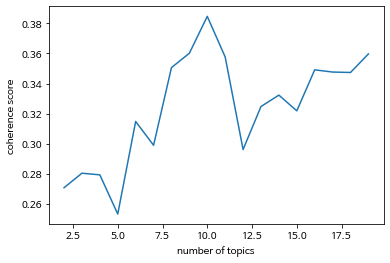

In [37]:
text_list = make_text_list(minzu)
min_rage_clean = Preproc(text_list)
min_rage_corpus, min_rage_dictionary, min_rage_cleanlist = make_corpus(min_rage_clean)
coh_visual(min_rage_corpus, min_rage_dictionary, min_rage_cleanlist)

2020-08-31 10:54:57,213 : INFO : using symmetric alpha at 0.5
2020-08-31 10:54:57,218 : INFO : using symmetric eta at 0.5
2020-08-31 10:54:57,223 : INFO : using serial LDA version on this node
2020-08-31 10:54:57,226 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 126 documents, updating model once every 126 documents, evaluating perplexity every 126 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 10:54:57,227 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 10:54:57,397 : INFO : -7.937 per-word bound, 245.0 perplexity estimate based on a held-out corpus of 126 documents with 12475 words
2020-08-31 10:54:57,398 : INFO : PROGRESS: pass 0, at document #126/126
2020-08-31 10:54:57,536 : INFO : topic #0 (0.500): 0.010*"근로" + 0.010*"최저임금" + 0.010*"장애인" + 0.010*"활동" + 0.009*"지급" + 0.009*"위원" + 0.008*"급여" + 0.008*"적용" + 

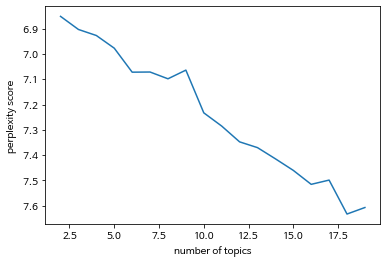

In [38]:
perp_visual(min_rage_corpus, min_rage_dictionary)

In [39]:
ldamodel = gensim.models.ldamodel.LdaModel(min_rage_corpus, num_topics=15, alpha=0.1, id2word = min_rage_dictionary)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, min_rage_corpus, min_rage_dictionary)
vis

2020-08-31 10:55:06,277 : INFO : using symmetric eta at 0.06666666666666667
2020-08-31 10:55:06,279 : INFO : using serial LDA version on this node
2020-08-31 10:55:06,287 : INFO : running online (single-pass) LDA training, 15 topics, 1 passes over the supplied corpus of 126 documents, updating model once every 126 documents, evaluating perplexity every 126 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 10:55:06,288 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 10:55:06,467 : INFO : -11.121 per-word bound, 2227.4 perplexity estimate based on a held-out corpus of 126 documents with 12475 words
2020-08-31 10:55:06,468 : INFO : PROGRESS: pass 0, at document #126/126
2020-08-31 10:55:06,608 : INFO : topic #4 (0.100): 0.026*"장애인" + 0.017*"계약" + 0.016*"서비스" + 0.014*"고용" + 0.010*"의무" + 0.009*"근로" + 0.009*"급여" + 0.009*"종사" + 0.008*"적용" + 0.008*"활동"
2020-08-31 10:55:06,

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.074697  0.038745       1        1  20.765564
2     -0.022605 -0.048958       2        1  12.995166
8      0.012961 -0.085260       3        1  12.468154
10     0.027858 -0.019818       4        1   8.861995
6      0.048934  0.070991       5        1   8.133257
7      0.058768 -0.019307       6        1   6.295742
13     0.117356  0.039052       7        1   5.732315
9     -0.043473  0.041211       8        1   5.612946
4     -0.020762  0.087316       9        1   4.188478
3      0.021046 -0.083933      10        1   3.546251
0     -0.006884 -0.043332      11        1   2.685139
14     0.001206 -0.006755      12        1   2.599265
5     -0.144654 -0.018308      13        1   2.336174
12     0.041721 -0.004004      14        1   2.310084
1     -0.016773  0.052361      15        1   1.469468, topic_info=     Term        Freq       Total Category  logprob  loglift
399    택시   48.000000   48.000000  Default  30.0000  30.0000
433    계약   74.000000   74.000000  Default  29.0000  29.0000
2      고용  120.000000  120.000000  Default  28.0000  28.0000
300    수급   67.000000   67.000000  Default  27.0000  27.0000
276    구직   37.000000   37.000000  Default  26.0000  26.0000
..    ...         ...         ...      ...      ...      ...
174    보장    0.958871   46.885162  Topic15  -5.2532   0.3306
165  최저임금    1.096456   98.672890  Topic15  -5.1191  -0.2795
61     수준    0.887868   72.468391  Topic15  -5.3301  -0.1818
118    제조    0.871611   83.245644  Topic15  -5.3486  -0.3389
102    법률    0.863371   77.196190  Topic15  -5.3581  -0.2730

[1005 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1247      1  0.176958   가격
1247      3  0.176958   가격
1247     13  0.530875   가격
891       9  0.455924  가까이
1324     10  0.702432   가맹
...     ...       ...  ...
839      12  0.054666   훈련
839      13  0.054666   훈련
342       1  0.771505   휴가
1445      1  0.349850   희생
1445      8  0.349850   희생

[2434 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 3, 9, 11, 7, 8, 14, 10, 5, 4, 1, 15, 6, 13, 2])

In [40]:
find_typical_topic(ldamodel, min_rage_corpus, min_rage_cleanlist)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9824,"위원, 공익, 고용, 청년, 결정, 보험, 법인, 활동, 제조, 지급","[교육, 기관, 정보공개, 특례법, 개정, 대학, 조교, 연구, 교육, 보조, 행정..."
1,1.0,0.9776,"계약, 임안, 구직, 가맹, 지급, 급여, 부담, 근로, 신설, 보호","[가맹, 거래, 정화, 일부, 법률, 법, 가맹, 점사, 업자, 단체, 가맹, 본부..."
2,2.0,0.9902,"활동, 장애인, 지급, 급여, 최저임금, 위원, 결정, 제조, 근로, 법률","[지뢰, 피해자, 특별법, 개정, 법, 지뢰, 사고, 피해, 유족, 위로, 의료, ..."
3,3.0,0.9924,"임차, 위원, 최저임금, 결정, 가맹, 심의, 소득, 제조, 근로, 대표","[상가, 건물, 임대차보호법, 개정, 안번, 발의, 연월일, 의, 김현아, 황영철,..."
4,4.0,0.9902,"장애인, 계약, 서비스, 고용, 의무, 근로, 급여, 종사, 적용, 활동","[서비스, 이용, 이용권, 개정, 법률, 서비스, 종사, 국민, 서비스, 직접, 수..."
5,5.0,0.9866,"사업자, 하도급, 수급, 조정, 대금, 신청, 활동, 변동, 급여, 장애인","[하도급, 거래, 정화, 일부, 업자, 로부터, 위탁, 수급, 사업자, 노무, 납품..."
6,6.0,0.9926,"고용, 장애인, 청년, 의무, 적용, 임안, 시설, 확대, 근로, 업자","[장애인, 고용, 촉진, 직업, 재활, 개정, 장애, 인복, 지법, 보호, 고용, ..."
7,7.0,0.9921,"택시, 종사, 운수, 지급, 노동, 근로, 근로시간, 경감, 급여, 운송","[특례, 개정, 전국, 여대, 보급, 여객, 수송, 담당, 국민, 이동, 편의, 증..."
8,8.0,0.9880,"결정, 지급, 적용, 위원, 근로, 제조, 심의, 노동자, 최저임금, 사용자","[일부, 법률, 국가, 결정, 과정, 개입, 최저, 수준, 결정, 사용자, 수준, ..."
9,9.0,0.9872,"계약, 근로, 조건, 고용, 일용, 급여, 활동, 만원, 상대자, 소득","[지방자치단체, 당사자, 계약, 일부, 법률, 구의역, 열차, 진입, 여부, 확인,..."


topic 4 병역
topic 5 골목상권

###### 3.3.2 통합당

2020-08-31 10:59:41,740 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-08-31 10:59:41,752 : INFO : built Dictionary(1495 unique tokens: ['가중', '간이', '개인', '개정', '경감']...) from 102 documents (total 9718 corpus positions)
2020-08-31 10:59:41,777 : INFO : using symmetric alpha at 0.5
2020-08-31 10:59:41,778 : INFO : using symmetric eta at 0.5
2020-08-31 10:59:41,780 : INFO : using serial LDA version on this node
2020-08-31 10:59:41,783 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 102 documents, updating model once every 102 documents, evaluating perplexity every 102 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 10:59:41,784 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 10:59:41,914 : INFO : -7.786 per-word bound, 220.8 perplexity estimate based on a held-out corpus of 102 documents with 9

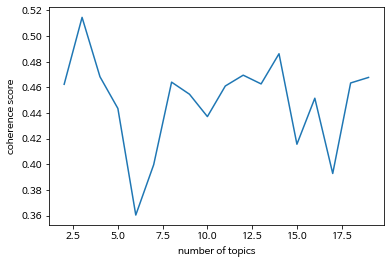

In [59]:
text_list = make_text_list(mirae)
min_rage_clean = Preproc(text_list)
min_rage_corpus, min_rage_dictionary, min_rage_cleanlist = make_corpus(min_rage_clean)
coh_visual(min_rage_corpus, min_rage_dictionary, min_rage_cleanlist)

2020-08-31 10:59:52,644 : INFO : using symmetric alpha at 0.5
2020-08-31 10:59:52,646 : INFO : using symmetric eta at 0.5
2020-08-31 10:59:52,648 : INFO : using serial LDA version on this node
2020-08-31 10:59:52,650 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 102 documents, updating model once every 102 documents, evaluating perplexity every 102 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 10:59:52,652 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 10:59:52,781 : INFO : -7.784 per-word bound, 220.4 perplexity estimate based on a held-out corpus of 102 documents with 9718 words
2020-08-31 10:59:52,782 : INFO : PROGRESS: pass 0, at document #102/102
2020-08-31 10:59:52,889 : INFO : topic #0 (0.500): 0.018*"위원" + 0.013*"결정" + 0.011*"적용" + 0.010*"고용" + 0.010*"법률" + 0.009*"최저임금" + 0.008*"사용자" + 0.008*"위원회" + 

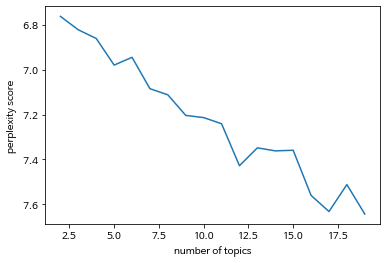

In [60]:
perp_visual(min_rage_corpus, min_rage_dictionary)

In [63]:
ldamodel = gensim.models.ldamodel.LdaModel(min_rage_corpus, num_topics=3, alpha=0.1, id2word = min_rage_dictionary)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, min_rage_corpus, min_rage_dictionary)
vis

2020-08-31 11:00:18,031 : INFO : using symmetric eta at 0.3333333333333333
2020-08-31 11:00:18,034 : INFO : using serial LDA version on this node
2020-08-31 11:00:18,037 : INFO : running online (single-pass) LDA training, 3 topics, 1 passes over the supplied corpus of 102 documents, updating model once every 102 documents, evaluating perplexity every 102 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 11:00:18,039 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 11:00:18,192 : INFO : -7.973 per-word bound, 251.2 perplexity estimate based on a held-out corpus of 102 documents with 9718 words
2020-08-31 11:00:18,193 : INFO : PROGRESS: pass 0, at document #102/102
2020-08-31 11:00:18,285 : INFO : topic #0 (0.100): 0.014*"적용" + 0.011*"고용" + 0.010*"법률" + 0.010*"외국인" + 0.009*"기업" + 0.009*"인상" + 0.009*"세율" + 0.008*"부담" + 0.008*"일부" + 0.007*"근로"
2020-08-31 11:00:18,286 : 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.034966  0.021977       1        1  35.072392
1     -0.014633 -0.028933       2        1  33.138844
2      0.049599  0.006957       3        1  31.788763, topic_info=     Term        Freq       Total Category  logprob  loglift
756    위원  104.000000  104.000000  Default  30.0000  30.0000
745    공익   39.000000   39.000000  Default  29.0000  29.0000
88    위원회   50.000000   50.000000  Default  28.0000  28.0000
1075   임차   16.000000   16.000000  Default  27.0000  27.0000
384   외국인   46.000000   46.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
51     적용   21.108089  103.035522   Topic3  -4.9860  -0.4394
294    경제   13.302306   34.667828   Topic3  -5.4477   0.1882
116    기업   15.666058   71.035690   Topic3  -5.2842  -0.3656
24     부담   15.101553   73.188232   Topic3  -5.3209  -0.4322
147    인상   14.238783   85.534088   Topic3  -5.3797  -0.6469

[246 rows x 6 columns], token_table=      Topic      Freq Term
term                      
566       1  0.162142   가입
566       2  0.648566   가입
566       3  0.324283   가입
952       1  0.875374   감당
3         1  0.391281   개정
...     ...       ...  ...
361       1  0.501084   현행
361       2  0.250542   현행
361       3  0.250542   현행
107       1  0.776226   회계
108       1  0.776553  후보자

[430 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

topic 2 는 젊은층의 아르바이트  
topic 5 는 국가에서 지급해야할 임금에 대한 것 ??

In [64]:
find_typical_topic(ldamodel, min_rage_corpus, min_rage_cleanlist)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9992,"적용, 고용, 법률, 외국인, 기업, 인상, 세율, 부담, 일부, 근로","[특례, 개정, 분기, 경제성장률, 전기, 대비, 기록, 금융위기, 분기, 이후, ..."
1,1.0,0.9991,"인상, 중소기업, 적용, 부담, 제도, 결정, 최저임금, 법률, 기업, 근로시간","[근로기준법, 상시, 지방자치단체, 공공기관, 최대, 근로시간, 단축, 개정, 근로..."
2,2.0,0.9990,"위원, 결정, 사용자, 위원회, 공익, 법률, 종류, 최저임금, 제조, 일부","[일부, 법률, 결정, 사회, 영향, 정책, 결정, 경제성장, 물가, 인상, 소득,..."


###### 3.3.3 정의당

2020-08-31 11:00:37,468 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-08-31 11:00:37,472 : INFO : built Dictionary(756 unique tokens: ['개월', '격차', '고시', '고용노동부', '관']...) from 25 documents (total 2410 corpus positions)
2020-08-31 11:00:37,479 : INFO : using symmetric alpha at 0.5
2020-08-31 11:00:37,481 : INFO : using symmetric eta at 0.5
2020-08-31 11:00:37,482 : INFO : using serial LDA version on this node
2020-08-31 11:00:37,484 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 25 documents, updating model once every 25 documents, evaluating perplexity every 25 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 11:00:37,486 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 11:00:37,524 : INFO : -7.199 per-word bound, 147.0 perplexity estimate based on a held-out corpus of 25 documents with 2410 

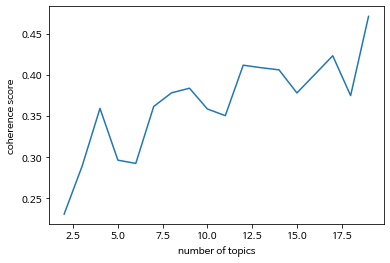

In [65]:
text_list = make_text_list(jeongwui)
min_rage_clean = Preproc(text_list)
min_rage_corpus, min_rage_dictionary, min_rage_cleanlist = make_corpus(min_rage_clean)
coh_visual(min_rage_corpus, min_rage_dictionary, min_rage_cleanlist)

2020-08-31 11:00:44,438 : INFO : using symmetric alpha at 0.5
2020-08-31 11:00:44,442 : INFO : using symmetric eta at 0.5
2020-08-31 11:00:44,444 : INFO : using serial LDA version on this node
2020-08-31 11:00:44,446 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 25 documents, updating model once every 25 documents, evaluating perplexity every 25 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 11:00:44,447 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 11:00:44,530 : INFO : -7.188 per-word bound, 145.8 perplexity estimate based on a held-out corpus of 25 documents with 2410 words
2020-08-31 11:00:44,531 : INFO : PROGRESS: pass 0, at document #25/25
2020-08-31 11:00:44,578 : INFO : topic #0 (0.500): 0.019*"계약" + 0.013*"지급" + 0.009*"최저임금" + 0.009*"근로" + 0.008*"임안" + 0.008*"법률" + 0.007*"국회의원" + 0.007*"조건" + 0.007*

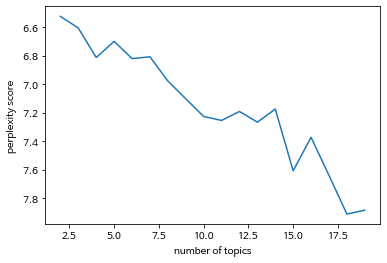

In [66]:
perp_visual(min_rage_corpus, min_rage_dictionary)

In [67]:
ldamodel = gensim.models.ldamodel.LdaModel(min_rage_corpus, num_topics=14, alpha=0.1, id2word = min_rage_dictionary)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, min_rage_corpus, min_rage_dictionary)
vis

2020-08-31 11:00:47,430 : INFO : using symmetric eta at 0.07142857142857142
2020-08-31 11:00:47,433 : INFO : using serial LDA version on this node
2020-08-31 11:00:47,438 : INFO : running online (single-pass) LDA training, 14 topics, 1 passes over the supplied corpus of 25 documents, updating model once every 25 documents, evaluating perplexity every 25 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 11:00:47,440 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 11:00:47,493 : INFO : -13.261 per-word bound, 9815.1 perplexity estimate based on a held-out corpus of 25 documents with 2410 words
2020-08-31 11:00:47,494 : INFO : PROGRESS: pass 0, at document #25/25
2020-08-31 11:00:47,535 : INFO : topic #1 (0.100): 0.033*"서비스" + 0.027*"종사" + 0.026*"계약" + 0.017*"근로" + 0.016*"조건" + 0.015*"제조" + 0.013*"제공" + 0.011*"신설" + 0.009*"지급" + 0.009*"상대자"
2020-08-31 11:00:47,537 : I

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.139436 -0.053260       1        1  20.853624
8     -0.122180  0.012322       2        1  18.311342
13     0.113887  0.015793       3        1  12.388470
3      0.038188  0.032034       4        1   8.384243
9     -0.081091  0.066510       5        1   7.845019
7      0.040096  0.021863       6        1   7.161447
1     -0.054747 -0.010412       7        1   5.936449
6     -0.027810 -0.138874       8        1   5.631262
5     -0.068527 -0.092272       9        1   5.091979
2      0.084223  0.009586      10        1   3.985238
11     0.000475  0.085173      11        1   2.451780
12    -0.031886  0.092983      12        1   1.755429
4     -0.043639 -0.041092      13        1   0.101860
0      0.013574 -0.000352      14        1   0.101857, topic_info=    Term       Freq      Total Category  logprob  loglift
309   계약  27.000000  27.000000  Default  30.0000  30.0000
77    활동  15.000000  15.000000  Default  29.0000  29.0000
308   가맹   8.000000   8.000000  Default  28.0000  28.0000
145  장애인  17.000000  17.000000  Default  27.0000  27.0000
26    보수  18.000000  18.000000  Default  26.0000  26.0000
..   ...        ...        ...      ...      ...      ...
209   필요   0.004077   6.017266  Topic14  -6.4005  -0.4078
63    제조   0.004185  19.191526  Topic14  -6.3742  -1.5413
59    장관   0.004130   9.937614  Topic14  -6.3876  -0.8965
148   적용   0.004124  13.497985  Topic14  -6.3890  -1.2041
150   정책   0.004066   8.110766  Topic14  -6.4032  -0.7090

[785 rows x 6 columns], token_table=      Topic      Freq Term
term                      
292       4  0.389304   가격
292      10  0.389304   가격
529       3  0.583609  가능성
308       2  0.122358   가맹
308       8  0.489431   가맹
...     ...       ...  ...
421       4  0.274933   훈련
421       6  0.137466   훈련
174       5  0.644144   휴업
175       2  0.405302   휴직
175       5  0.405302   휴직

[872 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 9, 14, 4, 10, 8, 2, 7, 6, 3, 12, 13, 5, 1])

topic 1은 장애인과 관련  
topic 2는 임대료와 관련  
topic 3는 법  
topic 4는 청소년  
topic 6는 골목상권

topic 1은 병역사고?   
topic 2는 국회의원의 보수  
topic 5는 장애인
topic 9는 병역
topic 10은 여성? 성노동?

In [68]:
find_typical_topic(ldamodel, min_rage_corpus, min_rage_cleanlist)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1.0,0.9909,"서비스, 종사, 계약, 근로, 조건, 제조, 제공, 신설, 지급, 상대자","[서비스, 이용, 이용권, 개정, 법률, 서비스, 종사, 국민, 서비스, 직접, 수..."
1,2.0,0.8145,"조정, 지급, 위로, 노동자, 하도급, 사업자, 국민, 결정, 보장, 미달","[일부, 법률, 국가, 결정, 과정, 개입, 최저, 수준, 결정, 사용자, 수준, ..."
2,3.0,0.9773,"일용, 사업자, 예비군, 근로, 조정, 활동, 인상, 하도급, 대금, 보상","[소득, 세법, 개정, 현행법, 일용, 부담, 완화, 일용, 일급, 만원, 정액, ..."
3,5.0,0.9795,"서비스, 가맹, 계약, 보수, 공공기관, 종사, 법률, 기관, 초과, 근로","[공공기관, 법률, 공공기관, 기관, 보수, 공공기관, 임원, 보수, 지침, 연도,..."
4,6.0,0.9844,"활동, 보수, 장애인, 가맹, 급여, 제공, 원인, 복무, 기관, 병사","[장애인, 활동, 개정, 법률, 법, 혼자, 일상생활, 사회생활, 장애인, 활동, ..."
5,7.0,0.9798,"지급, 도급, 업주, 의무, 처벌, 귀책사유, 노동자, 적용, 위반, 임안","[일부, 법률, 지급, 업주, 바로, 처벌, 반면, 미지, 귀책사유, 도급, 시정,..."
6,8.0,0.9880,"계약, 조건, 근로, 고용, 상대자, 당사자, 지방자치단체, 임안, 수준, 지급","[당사자, 계약, 일부, 법률, 구의역, 열차, 진입, 여부, 확인, 동료, 홀로,..."
7,9.0,0.9931,"장애인, 의무, 시설, 고용, 임안, 장애, 단체, 자치, 부문, 적용","[장애인, 고용, 촉진, 직업, 재활, 개정, 장애, 인복, 지법, 보호, 고용, ..."
8,10.0,0.9905,"국회의원, 보수, 지급, 제조, 수당, 인상, 노동자, 성별, 산정, 소득","[국회의원, 수당, 관, 일부, 현재, 국회의원, 연간, 지급, 세비, 일반, 수당..."
9,11.0,0.9781,"생활, 인간, 문화, 향상, 지방자치단체, 소득, 최저임금, 법률, 제도, 유지","[일부, 법률, 외환위기, 이후, 소득, 불평등, 심화, 최저임금, 평균, 정액, ..."


###### 3.3.4 국민의당

2020-08-31 11:00:52,521 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-08-31 11:00:52,529 : INFO : built Dictionary(952 unique tokens: ['각종', '개선', '개월', '격차', '고용노동부']...) from 47 documents (total 3783 corpus positions)
2020-08-31 11:00:52,541 : INFO : using symmetric alpha at 0.5
2020-08-31 11:00:52,542 : INFO : using symmetric eta at 0.5
2020-08-31 11:00:52,548 : INFO : using serial LDA version on this node
2020-08-31 11:00:52,551 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 47 documents, updating model once every 47 documents, evaluating perplexity every 47 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 11:00:52,552 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 11:00:52,626 : INFO : -7.392 per-word bound, 168.0 perplexity estimate based on a held-out corpus of 47 documents with 3783

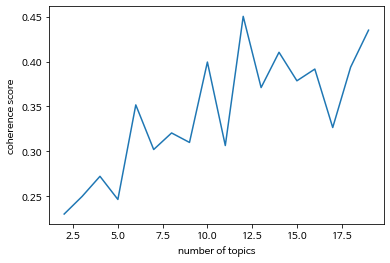

In [69]:
text_list = make_text_list(gookmin)
min_rage_clean = Preproc(text_list)
min_rage_corpus, min_rage_dictionary, min_rage_cleanlist = make_corpus(min_rage_clean)
coh_visual(min_rage_corpus, min_rage_dictionary, min_rage_cleanlist)

2020-08-31 11:01:00,152 : INFO : using symmetric alpha at 0.5
2020-08-31 11:01:00,153 : INFO : using symmetric eta at 0.5
2020-08-31 11:01:00,155 : INFO : using serial LDA version on this node
2020-08-31 11:01:00,157 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 47 documents, updating model once every 47 documents, evaluating perplexity every 47 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 11:01:00,158 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 11:01:00,297 : INFO : -7.395 per-word bound, 168.3 perplexity estimate based on a held-out corpus of 47 documents with 3783 words
2020-08-31 11:01:00,298 : INFO : PROGRESS: pass 0, at document #47/47
2020-08-31 11:01:00,342 : INFO : topic #0 (0.500): 0.013*"급여" + 0.013*"지급" + 0.013*"위원" + 0.011*"최저임금" + 0.008*"심의" + 0.008*"법률" + 0.007*"구직" + 0.007*"결정" + 0.007*"임

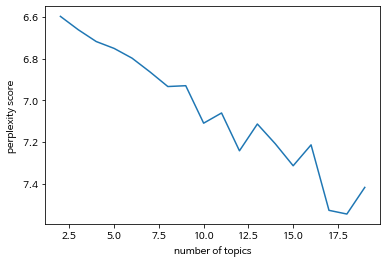

In [70]:
perp_visual(min_rage_corpus, min_rage_dictionary)

In [71]:
ldamodel = gensim.models.ldamodel.LdaModel(min_rage_corpus, num_topics=14, alpha=0.1, id2word = min_rage_dictionary)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, min_rage_corpus, min_rage_dictionary)
vis

2020-08-31 11:01:04,392 : INFO : using symmetric eta at 0.07142857142857142
2020-08-31 11:01:04,393 : INFO : using serial LDA version on this node
2020-08-31 11:01:04,399 : INFO : running online (single-pass) LDA training, 14 topics, 1 passes over the supplied corpus of 47 documents, updating model once every 47 documents, evaluating perplexity every 47 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 11:01:04,400 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 11:01:04,474 : INFO : -12.330 per-word bound, 5150.0 perplexity estimate based on a held-out corpus of 47 documents with 3783 words
2020-08-31 11:01:04,476 : INFO : PROGRESS: pass 0, at document #47/47
2020-08-31 11:01:04,528 : INFO : topic #10 (0.100): 0.023*"보수" + 0.020*"공공기관" + 0.014*"기관" + 0.013*"용역" + 0.013*"금액" + 0.012*"초과" + 0.012*"연도" + 0.010*"과세" + 0.009*"근로" + 0.009*"납부"
2020-08-31 11:01:04,529 : 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.003568  0.068491       1        1  17.661568
8      0.050791 -0.014533       2        1  10.698209
1     -0.024471  0.085139       3        1  10.410219
4     -0.105867 -0.062420       4        1   9.388750
7     -0.078859  0.062387       5        1   8.785979
13     0.073041  0.038930       6        1   6.954764
12     0.074214  0.051342       7        1   6.716224
0      0.027586  0.001869       8        1   6.582850
5      0.040977  0.004654       9        1   4.937750
3      0.094429 -0.142662      10        1   4.685410
9      0.083840  0.002048      11        1   4.255246
6     -0.062350  0.035078      12        1   4.141850
10    -0.069766 -0.119945      13        1   3.294391
11    -0.107133 -0.010376      14        1   1.486778, topic_info=     Term       Freq      Total Category  logprob  loglift
487    활동  19.000000  19.000000  Default  30.0000  30.0000
108    위원  27.000000  27.000000  Default  29.0000  29.0000
258   장애인  17.000000  17.000000  Default  28.0000  28.0000
146    급여  42.000000  42.000000  Default  27.0000  27.0000
178    구직  34.000000  34.000000  Default  26.0000  26.0000
..    ...        ...        ...      ...      ...      ...
123    고용   0.458206  38.010857  Topic14  -4.8102  -0.2098
66     제조   0.358386  18.694048  Topic14  -5.0559   0.2542
31     법률   0.393075  31.915247  Topic14  -4.9635  -0.1883
140    청년   0.335467  23.133512  Topic14  -5.1219  -0.0250
77   최저임금   0.336362  43.206013  Topic14  -5.1193  -0.6470

[806 rows x 6 columns], token_table=      Topic      Freq Term
term                      
734       7  0.579664   가목
735       1  0.185806   가입
735       3  0.185806   가입
735       6  0.185806   가입
735       7  0.371612   가입
...     ...       ...  ...
240      12  0.125841   회의
312       1  0.310321   후단
312       6  0.310321   후단
312       9  0.310321   후단
854       9  0.679624   휴직

[1296 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 2, 5, 8, 14, 13, 1, 6, 4, 10, 7, 11, 12])

topic 10은 양육  
topic 11은 중소기업

## 4. '최저임금'과 관련된 키워드 분석
- 사용된 키워드는 최저임금, 임금, 일급, 시급, 생활임금

In [72]:
print("'최저임금' 키워드만 들어간 법안의 수 ",min_rage.shape)
print("'최저임금과 관련된 키워드'를 포함했을 경우 법안의 수", rage.shape)

'최저임금' 키워드만 들어간 법안의 수  (231, 34)
'최저임금과 관련된 키워드'를 포함했을 경우 법안의 수 (657, 34)


#### 4.1 법안은 언제 발의됐는가

Text(0.5, 1.0, '월별 최저임금 관련 법안 발의 건수')

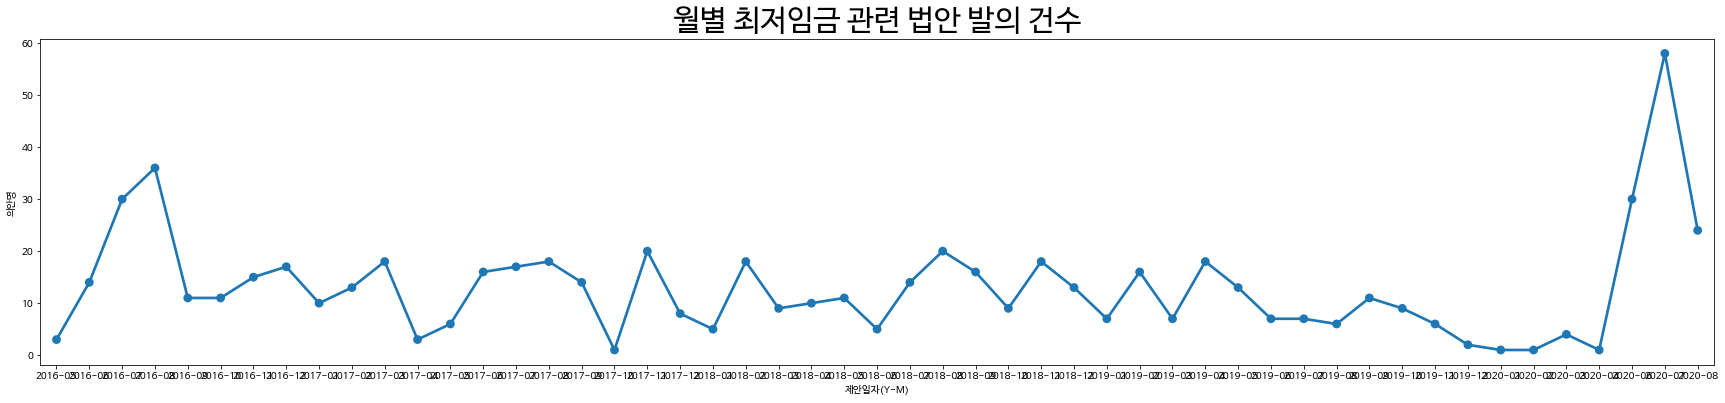

In [73]:
rage_proposer_date = pd.DataFrame(rage.groupby('제안일자(Y-M)')['의안명'].count())
plt.figure(figsize = (30,6))
sns.pointplot(data = rage_proposer_date, x = rage_proposer_date.index, y='의안명')
plt.title('월별 최저임금 관련 법안 발의 건수', fontsize=30)

크게 다르지않지만 __21대 국회의 시작__과 함께 폭증한 관련법

#### 4.2 법안 토픽모델링

2020-08-31 11:01:56,196 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-08-31 11:01:56,287 : INFO : built Dictionary(4584 unique tokens: ['가장', '감안', '개', '개정', '격차']...) from 657 documents (total 83020 corpus positions)
2020-08-31 11:01:56,347 : INFO : using symmetric alpha at 0.5
2020-08-31 11:01:56,348 : INFO : using symmetric eta at 0.5
2020-08-31 11:01:56,351 : INFO : using serial LDA version on this node
2020-08-31 11:01:56,355 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 657 documents, updating model once every 657 documents, evaluating perplexity every 657 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 11:01:56,357 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 11:01:57,172 : INFO : -8.848 per-word bound, 461.0 perplexity estimate based on a held-out corpus of 657 documents with 8

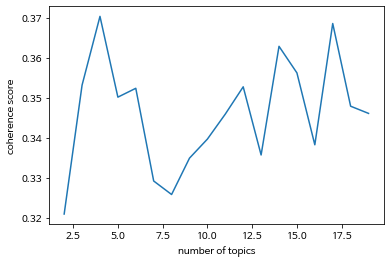

CPU times: user 51 s, sys: 3.55 s, total: 54.6 s
Wall time: 51.1 s


In [74]:
text_list = make_text_list(rage)
min_rage_clean = Preproc(text_list)
min_rage_corpus, min_rage_dictionary, min_rage_cleanlist = make_corpus(min_rage_clean)
%time coh_visual(min_rage_corpus, min_rage_dictionary, min_rage_cleanlist)

2020-08-31 11:02:47,473 : INFO : using symmetric alpha at 0.5
2020-08-31 11:02:47,474 : INFO : using symmetric eta at 0.5
2020-08-31 11:02:47,478 : INFO : using serial LDA version on this node
2020-08-31 11:02:47,482 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 657 documents, updating model once every 657 documents, evaluating perplexity every 657 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 11:02:47,483 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 11:02:48,295 : INFO : -8.848 per-word bound, 461.0 perplexity estimate based on a held-out corpus of 657 documents with 83020 words
2020-08-31 11:02:48,296 : INFO : PROGRESS: pass 0, at document #657/657
2020-08-31 11:02:48,882 : INFO : topic #0 (0.500): 0.009*"제조" + 0.009*"고용" + 0.009*"근로" + 0.009*"지급" + 0.006*"개정" + 0.005*"법률" + 0.005*"적용" + 0.005*"기간" + 0.0

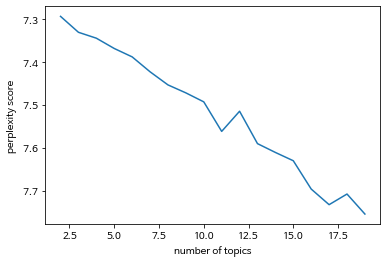

In [75]:
perp_visual(min_rage_corpus, min_rage_dictionary)

In [76]:
ldamodel = gensim.models.ldamodel.LdaModel(min_rage_corpus, num_topics=11, alpha=0.1, id2word = min_rage_dictionary)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, min_rage_corpus, min_rage_dictionary)
vis

2020-08-31 11:03:31,901 : INFO : using symmetric eta at 0.09090909090909091
2020-08-31 11:03:31,905 : INFO : using serial LDA version on this node
2020-08-31 11:03:31,916 : INFO : running online (single-pass) LDA training, 11 topics, 1 passes over the supplied corpus of 657 documents, updating model once every 657 documents, evaluating perplexity every 657 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 11:03:31,917 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 11:03:32,857 : INFO : -9.763 per-word bound, 869.1 perplexity estimate based on a held-out corpus of 657 documents with 83020 words
2020-08-31 11:03:32,858 : INFO : PROGRESS: pass 0, at document #657/657
2020-08-31 11:03:33,522 : INFO : topic #2 (0.100): 0.021*"지급" + 0.011*"제조" + 0.007*"체불" + 0.006*"근로" + 0.006*"법률" + 0.006*"고용" + 0.006*"보장" + 0.006*"개정" + 0.005*"보호" + 0.005*"임안"
2020-08-31 11:03:33,524 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.041022 -0.004184       1        1  14.225008
5     -0.010411 -0.017505       2        1  13.294667
9      0.040993 -0.020686       3        1  12.565764
3      0.003642  0.045730       4        1  11.250393
7     -0.056468 -0.048367       5        1  10.573750
2     -0.045597  0.044022       6        1   9.111339
8     -0.005957 -0.013628       7        1   7.268708
6      0.014185  0.015892       8        1   6.787166
1      0.031388 -0.005018       9        1   6.457952
10    -0.011096  0.020846      10        1   5.070470
0     -0.001700 -0.017101      11        1   3.394783, topic_info=     Term        Freq       Total Category  logprob  loglift
240    지급  626.000000  626.000000  Default  30.0000  30.0000
192  중소기업  448.000000  448.000000  Default  29.0000  29.0000
56     근로  796.000000  796.000000  Default  28.0000  28.0000
764    체불  211.000000  211.000000  Default  27.0000  27.0000
741  근로시간  236.000000  236.000000  Default  26.0000  26.0000
..    ...         ...         ...      ...      ...      ...
3      개정   11.976113  456.859314  Topic11  -5.4610  -0.2585
240    지급   12.575375  626.389465  Topic11  -5.4122  -0.5253
145    제도   10.947568  498.505524  Topic11  -5.5508  -0.4356
71     소득   10.366964  422.921722  Topic11  -5.6053  -0.3256
409    법률   10.010649  378.686554  Topic11  -5.6403  -0.2501

[891 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2979      3  0.570575  가까이
2979      8  0.190192  가까이
1218      6  0.790816   가담
1264      1  0.092297   가맹
1264      2  0.123062   가맹
...     ...       ...  ...
697       7  0.054879   휴일
697       8  0.128050   휴일
697       9  0.164636   휴일
697      10  0.036586   휴일
697      11  0.018293   휴일

[3325 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 10, 4, 8, 3, 9, 7, 2, 11, 1])

topic1 은 군대
topic3 은 어린이, 양육

## 5. 당별 의안데이터를 하나의 인덱스로 만들어서 분석

>LDA의 가정
- __문서는 여러개의 토픽을 지닐 수 있고__ 한 문서는 특정 토픽을 얼마나 지녔는지의 확률로 계산된다.
- 하나의 토픽은 해당 토픽에서 이용되는 단어의 비율로 표현된다

LDA는 어떤 단어가 하나의 토픽에 압도적으로 많이 등장할 수록 성능이 증가.  
그래서 문서의 길이가 짧으면 토픽을 뽑아내기 힘든 경우가 많음  
-> 그렇다면 당별 의안내용을 하나의 인덱스로 만들면 문서의 길이를 늘릴 수 있지 않을까 ?? 

#### 5.1 정당별 데이터를 하나의 인덱스로 만들기

In [77]:
cond1 = min_rage['더불어민주당'] == 1
cond2 = min_rage['더불어시민당'] == 1

cond5 = min_rage['미래통합당'] == 1
cond6 = min_rage['미래한국당'] == 1

minzu_rage = min_rage[cond1 | cond2]
mirae_rage = min_rage[cond5 | cond6]
jayu_rage = min_rage[min_rage['자유한국당'] == 1]
jeongwui_rage = min_rage[min_rage['정의당'] == 1]
gookmin_rage = min_rage[min_rage['국민의당'] == 1]
bareun_rage = min_rage[min_rage['바른미래당'] == 1]

print(minzu_rage.shape)
print(mirae_rage.shape)
print(jayu_rage.shape)
print(jeongwui_rage.shape)
print(gookmin_rage.shape)
print(bareun_rage.shape)

(126, 34)
(27, 34)
(71, 34)
(25, 34)
(47, 34)
(34, 34)


In [78]:
# 정당별 칼럼 만들기 -> 중복처리는 우선 하지 않음
party_list = [minzu_rage, jayu_rage, mirae_rage, jeongwui_rage, gookmin_rage, bareun_rage]
bill_text_list = []
party_bill_list = []

for i in party_list:
  for j in i['의안명+제안이유']:
    bill_text_list.append(j)
  party_bill_list.append(str(bill_text_list))
  bill_text_list = []

In [79]:
party_total_df = pd.DataFrame(party_bill_list, columns = ['의안명+제안이유'])
party_total_df['정당명'] = ['더불어민주당', '자유한국당', '미래통합당', '정의당', '국민의당', '바른미래당']
party_total_df

,의안명+제안이유,정당명
0,['소득세법 일부개정법률안 법은 일용근로자의 세부담을 완화하기 위하여 일용근로자의 ...,더불어민주당
1,['공직선거법 일부개정법률안 법은 예비후보자 및 후보자의 선거운동과 선거비용의 회계...,자유한국당
2,['부가가치세법 일부개정법률안 법은 직전 연도의 재화와 용역의 공급에 대한 대가의 ...,미래통합당
3,['국회의원수당 등에 관한 법률 일부개정법률안 년 현재 국회의원에게 연간 지급되는 ...,정의당
4,['최저임금법 일부개정법률안 노동기구에서 밝히고 있는 최저임금제도의 목적은 부당한 ...,국민의당
5,['소득세법 일부개정법률안 법은 일용근로자의 세부담을 완화하기 위하여 일용근로자의 ...,바른미래당


#### 5.2 토픽모델링

2020-08-31 11:03:56,610 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-08-31 11:03:56,632 : INFO : built Dictionary(2335 unique tokens: ['가가', '가격', '가구', '가까이', '가능성']...) from 6 documents (total 30833 corpus positions)
2020-08-31 11:03:56,657 : INFO : using symmetric alpha at 0.5
2020-08-31 11:03:56,658 : INFO : using symmetric eta at 0.5
2020-08-31 11:03:56,660 : INFO : using serial LDA version on this node
2020-08-31 11:03:56,663 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 6 documents, updating model once every 6 documents, evaluating perplexity every 6 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 11:03:56,664 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 11:03:56,709 : INFO : -8.170 per-word bound, 288.0 perplexity estimate based on a held-out corpus of 6 documents with 30833 wo

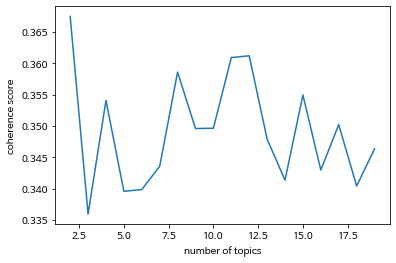

CPU times: user 22 s, sys: 2.67 s, total: 24.6 s
Wall time: 22.3 s


In [80]:
text_list = make_text_list(party_total_df)
min_rage_clean = Preproc(text_list)
min_rage_corpus, min_rage_dictionary, min_rage_cleanlist = make_corpus(min_rage_clean)
%time coh_visual(min_rage_corpus, min_rage_dictionary, min_rage_cleanlist)

2020-08-31 11:04:18,969 : INFO : using symmetric alpha at 0.5
2020-08-31 11:04:18,971 : INFO : using symmetric eta at 0.5
2020-08-31 11:04:18,974 : INFO : using serial LDA version on this node
2020-08-31 11:04:18,977 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 6 documents, updating model once every 6 documents, evaluating perplexity every 6 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 11:04:18,979 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 11:04:19,029 : INFO : -8.166 per-word bound, 287.2 perplexity estimate based on a held-out corpus of 6 documents with 30833 words
2020-08-31 11:04:19,030 : INFO : PROGRESS: pass 0, at document #6/6
2020-08-31 11:04:19,045 : INFO : topic #0 (0.500): 0.010*"지급" + 0.010*"최저임금" + 0.009*"근로" + 0.009*"고용" + 0.009*"결정" + 0.009*"장애인" + 0.008*"적용" + 0.008*"임안" + 0.007*"개정" +

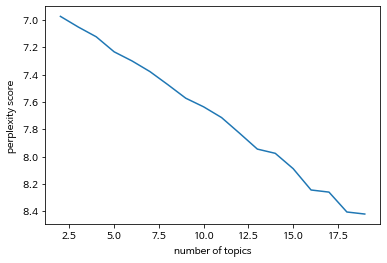

In [81]:
perp_visual(min_rage_corpus, min_rage_dictionary)

In [82]:
ldamodel = gensim.models.ldamodel.LdaModel(min_rage_corpus, num_topics=11, alpha=0.1, id2word = min_rage_dictionary)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, min_rage_corpus, min_rage_dictionary)
vis

2020-08-31 11:04:23,117 : INFO : using symmetric eta at 0.09090909090909091
2020-08-31 11:04:23,119 : INFO : using serial LDA version on this node
2020-08-31 11:04:23,127 : INFO : running online (single-pass) LDA training, 11 topics, 1 passes over the supplied corpus of 6 documents, updating model once every 6 documents, evaluating perplexity every 6 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 11:04:23,128 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 11:04:23,210 : INFO : -9.270 per-word bound, 617.5 perplexity estimate based on a held-out corpus of 6 documents with 30833 words
2020-08-31 11:04:23,211 : INFO : PROGRESS: pass 0, at document #6/6
2020-08-31 11:04:23,244 : INFO : topic #0 (0.100): 0.009*"근로" + 0.008*"개정" + 0.008*"적용" + 0.007*"장애인" + 0.007*"위원" + 0.006*"지급" + 0.006*"최저임금" + 0.006*"법률" + 0.006*"임안" + 0.006*"제조"
2020-08-31 11:04:23,245 : INFO : 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.002532 -0.004235       1        1  70.812973
4      0.010059 -0.000565       2        1  14.709878
10    -0.000839 -0.001720       3        1  10.422407
5     -0.006684 -0.000450       4        1   1.974725
9     -0.000060  0.000027       5        1   1.764921
3     -0.000729 -0.002165       6        1   0.247676
6      0.000009  0.000397       7        1   0.027222
2      0.000151  0.001085       8        1   0.020121
7     -0.005034  0.001907       9        1   0.014083
1      0.005625 -0.000328      10        1   0.004041
0      0.000034  0.006046      11        1   0.001948, topic_info=      Term        Freq       Total Category  logprob  loglift
1392    지급  319.000000  319.000000  Default  30.0000  30.0000
1234    적용  300.000000  300.000000  Default  29.0000  29.0000
111     고용  294.000000  294.000000  Default  28.0000  28.0000
1034    위원  281.000000  281.000000  Default  27.0000  27.0000
78      결정  292.000000  292.000000  Default  26.0000  26.0000
...    ...         ...         ...      ...      ...      ...
245     금액    0.002447  167.931717  Topic11  -5.5029  -0.2902
1121    인상    0.002712  220.859009  Topic11  -5.4001  -0.4613
1298    제도    0.002305  159.421478  Topic11  -5.5629  -0.2981
1138    일부    0.002212  151.108093  Topic11  -5.6037  -0.2854
1368  중소기업    0.002016  122.979034  Topic11  -5.6965  -0.1721

[939 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1754      1  0.630092   가계
1754      2  0.315046   가계
4         1  0.619769  가능성
4         2  0.275453  가능성
4         3  0.137726  가능성
...     ...       ...  ...
1736      2  0.183942   효력
1736      3  0.183942   효력
1741      1  0.591166  후보자
1741      2  0.197055  후보자
1741      3  0.197055  후보자

[1318 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 5, 11, 6, 10, 4, 7, 3, 8, 2, 1])

## 6. K-means를 활용한 토픽모델링

LDA는 문서당 여러개의 토픽이 포함될 수 있다고 가정.  
하지만 __문서 하나당 한개의 토픽__만 있다면 K-means로 문서를 군집화하는 것도 좋음

## 7. 코로나 관련 키워드 뽑아내기

In [83]:
## '산재', '과로사' 등과 같이 쓰이는 단어 목록
print(model.wv.most_similar('감염병'))

[('감염', 0.7527188658714294), ('염병', 0.6689997911453247), ('유행', 0.6549795866012573), ('전염병', 0.6447092294692993), ('바이러스병', 0.6403629779815674), ('보균자', 0.6290343403816223), ('제군', 0.6154451966285706), ('장염', 0.6101583242416382), ('검역', 0.5934246778488159), ('잠복기간', 0.5927326679229736)]


In [84]:
keyword = r'.*(감염병|감염증|전염병|방역).*'
covid = bill_df[bill_df['의안명'].str.match(keyword) | bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]
print(covid.shape)
covid.head()

(509, 34)


,의안번호,의안명,제안자구분,제안회기,제안이유,소관위원회,제안정당,법률공포여부,개혁보수신당,국민의당,기본소득당,대안신당,대한애국당,더불어민주당,더불어시민당,무소속,미래를향한전진4.0,미래통합당,미래한국당,민생당,민주평화당,민중당,바른미래당,바른정당,새누리당,새로운보수당,새민중정당,시대전환,열린민주당,우리공화당,자유한국당,정의당,의안명+제안이유,제안일자(Y-M)
56,2024935,출입국관리법 일부개정법률안,위원장,제20대 (2016~2020) 제378회,출입국 전 과정에서 지문 얼굴을 비롯하여 홍채 손바닥 정맥 등 생체정보를 이용...,법제사법위원회,['더불어민주당'],공포,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,출입국관리법 일부개정법률안 출입국 전 과정에서 지문 얼굴을 비롯하여 홍채 손바...,2020-05
96,2024888,생명공학육성법 일부개정법률안,위원장,제20대 (2016~2020) 제377회,의 생명공학은 고령화 감염병 식량안보 기후변화 등 인류가 당면한 문제들을 해결...,과학기술정보방송통신위원회,['더불어민주당'],공포,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,생명공학육성법 일부개정법률안 의 생명공학은 고령화 감염병 식량안보 기후변화 등...,2020-04
109,2024873,조세특례제한법 일부개정법률안,의원,제20대 (2016~2020) 제377회,코로나바이러스감염증 이하 코로나의 국내 확산 이후 강력한 방역 대응 과정에서 소...,기획재정위원회,['미래통합당'],미공포,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,조세특례제한법 일부개정법률안 코로나바이러스감염증 이하 코로나의 국내 확산 이후 ...,2020-04
110,2024872,조세특례제한법 일부개정법률안,의원,제20대 (2016~2020) 제377회,코로나바이러스감염증 이하 코로나의 국내 확산이 장기화됨으로써 경제활동 위축과 실...,기획재정위원회,"['무소속', '더불어시민당', '민생당']",미공포,0.0,0.0,0.0,0.0,0.0,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,조세특례제한법 일부개정법률안 코로나바이러스감염증 이하 코로나의 국내 확산이 장기...,2020-04
111,2024871,부가가치세법 일부개정법률안,의원,제20대 (2016~2020) 제377회,코로나바이러스감염증 이하 코로나 라 함의 국내 확산이 장기화됨으로써 경제활동 ...,기획재정위원회,"['무소속', '더불어시민당', '민생당']",미공포,0.0,0.0,0.0,0.0,0.0,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,부가가치세법 일부개정법률안 코로나바이러스감염증 이하 코로나 라 함의 국내 확산...,2020-04


In [85]:
covid_proposer_date = pd.DataFrame(covid.groupby('제안일자(Y-M)')['의안명'].count())
covid_proposer_date.head()

,의안명
제안일자(Y-M),
2016-06,4
2016-07,2
2016-08,5
2016-09,7
2016-10,3


Text(0.5, 1.0, '월별 감영병 관련 법안 발의 건수')

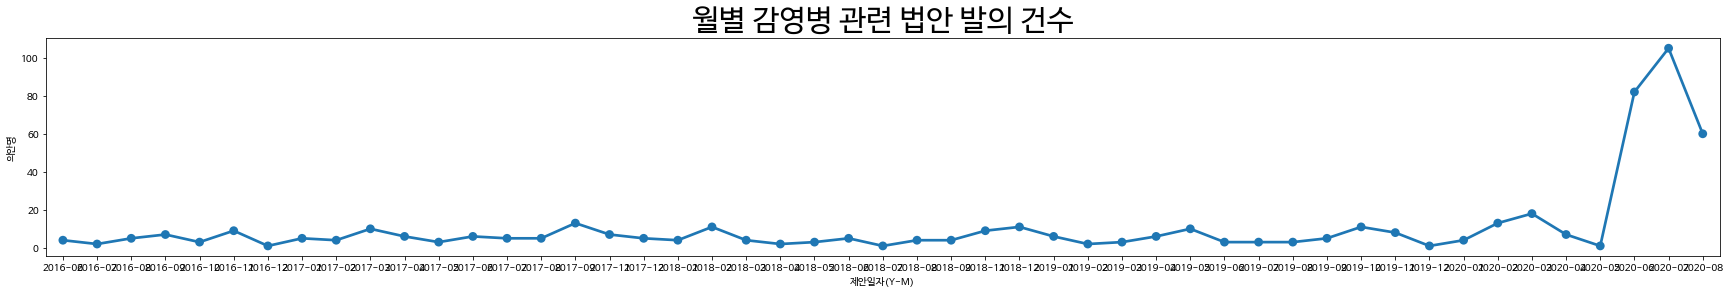

In [86]:
plt.figure(figsize = (30,4))
sns.pointplot(data = covid_proposer_date, x=covid_proposer_date.index, y='의안명')
plt.title('월별 감영병 관련 법안 발의 건수', fontsize=30)

2020-08-31 11:04:56,611 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-08-31 11:04:56,676 : INFO : built Dictionary(3973 unique tokens: ['각종', '감염병', '개정', '개정안', '경보']...) from 509 documents (total 53669 corpus positions)
2020-08-31 11:04:56,726 : INFO : using symmetric alpha at 0.5
2020-08-31 11:04:56,727 : INFO : using symmetric eta at 0.5
2020-08-31 11:04:56,728 : INFO : using serial LDA version on this node
2020-08-31 11:04:56,731 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 509 documents, updating model once every 509 documents, evaluating perplexity every 509 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 11:04:56,732 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 11:04:57,333 : INFO : -8.716 per-word bound, 420.5 perplexity estimate based on a held-out corpus of 509 documents wit

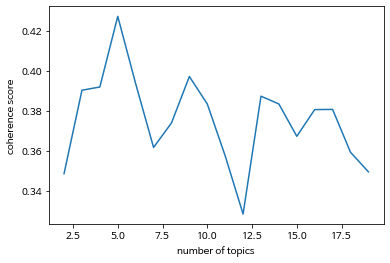

CPU times: user 33.8 s, sys: 732 ms, total: 34.5 s
Wall time: 34.1 s


In [87]:
text_list = make_text_list(covid)
covid_clean = Preproc(text_list)
covid_corpus, covid_dictionary, covid_cleanlist = make_corpus(covid_clean)
%time coh_visual(covid_corpus, covid_dictionary, covid_cleanlist)

2020-08-31 11:05:30,795 : INFO : using symmetric alpha at 0.5
2020-08-31 11:05:30,797 : INFO : using symmetric eta at 0.5
2020-08-31 11:05:30,801 : INFO : using serial LDA version on this node
2020-08-31 11:05:30,805 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 509 documents, updating model once every 509 documents, evaluating perplexity every 509 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 11:05:30,807 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 11:05:31,435 : INFO : -8.721 per-word bound, 422.0 perplexity estimate based on a held-out corpus of 509 documents with 53669 words
2020-08-31 11:05:31,436 : INFO : PROGRESS: pass 0, at document #509/509
2020-08-31 11:05:31,888 : INFO : topic #0 (0.500): 0.014*"감염병" + 0.009*"제조" + 0.008*"개정" + 0.008*"의료" + 0.008*"가축" + 0.007*"법률" + 0.007*"예방" + 0.007*"전염병" + 0

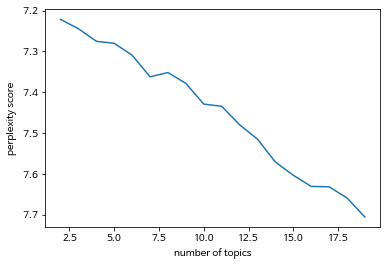

In [88]:
perp_visual(covid_corpus, covid_dictionary)

In [89]:
ldamodel = gensim.models.ldamodel.LdaModel(covid_corpus, num_topics=13, alpha=0.1, id2word = covid_dictionary)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, covid_corpus, covid_dictionary)
vis

2020-08-31 11:06:03,169 : INFO : using symmetric eta at 0.07692307692307693
2020-08-31 11:06:03,174 : INFO : using serial LDA version on this node
2020-08-31 11:06:03,187 : INFO : running online (single-pass) LDA training, 13 topics, 1 passes over the supplied corpus of 509 documents, updating model once every 509 documents, evaluating perplexity every 509 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 11:06:03,189 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 11:06:03,883 : INFO : -10.197 per-word bound, 1173.5 perplexity estimate based on a held-out corpus of 509 documents with 53669 words
2020-08-31 11:06:03,890 : INFO : PROGRESS: pass 0, at document #509/509
2020-08-31 11:06:04,413 : INFO : topic #9 (0.100): 0.022*"감염병" + 0.010*"질병" + 0.009*"보건" + 0.008*"감염" + 0.008*"의료" + 0.008*"국제" + 0.008*"예방" + 0.007*"제조" + 0.007*"활동" + 0.007*"개정"
2020-08-31 11:06:04,4

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.004296  0.047114       1        1  13.899082
7      0.012756  0.004660       2        1  12.009197
11    -0.012242  0.036842       3        1   9.373228
2     -0.005932  0.022115       4        1   8.572857
6      0.053643 -0.002336       5        1   7.980116
10     0.025071  0.012661       6        1   7.919159
5      0.011020  0.004364       7        1   7.616562
1      0.007277 -0.066891       8        1   6.836376
3     -0.019255  0.009388       9        1   6.026176
9      0.020811  0.022260      10        1   5.965756
12    -0.068946  0.019524      11        1   5.080076
4      0.050413 -0.047038      12        1   4.550123
8     -0.070321 -0.062664      13        1   4.171286, topic_info=         Term         Freq        Total Category  logprob  loglift
481        재난   280.000000   280.000000  Default  30.0000  30.0000
1087       가축   434.000000   434.000000  Default  29.0000  29.0000
1         감염병  1059.000000  1059.000000  Default  28.0000  28.0000
1256     예방접종   107.000000   107.000000  Default  27.0000  27.0000
2224       체육    71.000000    71.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
341   코로나바이러스     7.978221   156.605957  Topic13  -5.6369   0.1999
1         감염병    11.527353  1059.629761  Topic13  -5.2689  -1.3440
486        최근     7.946216   161.537933  Topic13  -5.6409   0.1649
344        확산     8.488453   257.887207  Topic13  -5.5749  -0.2369
45         법률     8.346108   309.121185  Topic13  -5.5918  -0.4350

[1013 rows x 6 columns], token_table=      Topic      Freq Term
term                      
823       1  0.391613   가격
823       2  0.030124   가격
823       3  0.090372   가격
823       4  0.090372   가격
823       5  0.030124   가격
...     ...       ...  ...
685       9  0.012600   휴가
685      10  0.088201   휴가
685      11  0.025200   휴가
685      12  0.063001   휴가
685      13  0.012600   휴가

[3697 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 12, 3, 7, 11, 6, 2, 4, 10, 13, 5, 9])

###### 코로나로만

In [90]:
keyword = r'.*(코로나).*'
covid_df = bill_df[bill_df['의안명'].str.match(keyword) | bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]
print(covid_df.shape)
covid_df.head()

(417, 34)


,의안번호,의안명,제안자구분,제안회기,제안이유,소관위원회,제안정당,법률공포여부,개혁보수신당,국민의당,기본소득당,대안신당,대한애국당,더불어민주당,더불어시민당,무소속,미래를향한전진4.0,미래통합당,미래한국당,민생당,민주평화당,민중당,바른미래당,바른정당,새누리당,새로운보수당,새민중정당,시대전환,열린민주당,우리공화당,자유한국당,정의당,의안명+제안이유,제안일자(Y-M)
109,2024873,조세특례제한법 일부개정법률안,의원,제20대 (2016~2020) 제377회,코로나바이러스감염증 이하 코로나의 국내 확산 이후 강력한 방역 대응 과정에서 소...,기획재정위원회,['미래통합당'],미공포,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,조세특례제한법 일부개정법률안 코로나바이러스감염증 이하 코로나의 국내 확산 이후 ...,2020-04
110,2024872,조세특례제한법 일부개정법률안,의원,제20대 (2016~2020) 제377회,코로나바이러스감염증 이하 코로나의 국내 확산이 장기화됨으로써 경제활동 위축과 실...,기획재정위원회,"['무소속', '더불어시민당', '민생당']",미공포,0.0,0.0,0.0,0.0,0.0,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,조세특례제한법 일부개정법률안 코로나바이러스감염증 이하 코로나의 국내 확산이 장기...,2020-04
111,2024871,부가가치세법 일부개정법률안,의원,제20대 (2016~2020) 제377회,코로나바이러스감염증 이하 코로나 라 함의 국내 확산이 장기화됨으로써 경제활동 ...,기획재정위원회,"['무소속', '더불어시민당', '민생당']",미공포,0.0,0.0,0.0,0.0,0.0,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,부가가치세법 일부개정법률안 코로나바이러스감염증 이하 코로나 라 함의 국내 확산...,2020-04
125,2024851,조세특례제한법 일부개정법률안,의원,제20대 (2016~2020) 제377회,코로나바이러스감염증 이하 코로나의 국내 확산 이후 강력한 방역 대응 과정에서 소...,기획재정위원회,"['더불어민주당', '더불어시민당']",미공포,0.0,0.0,0.0,0.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,조세특례제한법 일부개정법률안 코로나바이러스감염증 이하 코로나의 국내 확산 이후 ...,2020-04
132,2024833,재난 및 안전관리 기본법 일부개정법률안,의원,제20대 (2016~2020) 제376회,법은 대규모 재난의 대응 복구를 위하여 중앙재난안전대책본부이하 중앙대책본부 라 한...,행정안전위원회,['더불어민주당'],미공포,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,재난 및 안전관리 기본법 일부개정법률안 법은 대규모 재난의 대응 복구를 위하여 중앙...,2020-04


2020-08-31 11:06:34,775 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-08-31 11:06:34,830 : INFO : built Dictionary(3290 unique tokens: ['가중', '감염증', '개월', '개인', '개정']...) from 417 documents (total 44378 corpus positions)
2020-08-31 11:06:34,876 : INFO : using symmetric alpha at 0.5
2020-08-31 11:06:34,877 : INFO : using symmetric eta at 0.5
2020-08-31 11:06:34,880 : INFO : using serial LDA version on this node
2020-08-31 11:06:34,883 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 417 documents, updating model once every 417 documents, evaluating perplexity every 417 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 11:06:34,884 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 11:06:35,382 : INFO : -8.531 per-word bound, 369.8 perplexity estimate based on a held-out corpus of 417 documents with

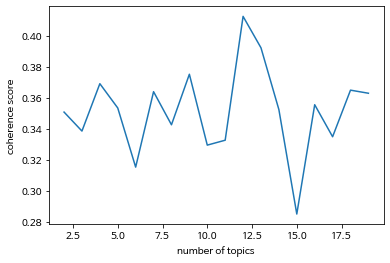

CPU times: user 28.5 s, sys: 681 ms, total: 29.2 s
Wall time: 28.8 s


In [91]:
text_list = make_text_list(covid_df)
covid_df_clean = Preproc(text_list)
covid_df_corpus, covid_df_dictionary, covid_df_cleanlist = make_corpus(covid_df_clean)
%time coh_visual(covid_df_corpus, covid_df_dictionary, covid_df_cleanlist)

2020-08-31 11:07:03,643 : INFO : using symmetric alpha at 0.5
2020-08-31 11:07:03,646 : INFO : using symmetric eta at 0.5
2020-08-31 11:07:03,648 : INFO : using serial LDA version on this node
2020-08-31 11:07:03,655 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 417 documents, updating model once every 417 documents, evaluating perplexity every 417 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 11:07:03,657 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 11:07:04,185 : INFO : -8.523 per-word bound, 367.9 perplexity estimate based on a held-out corpus of 417 documents with 44378 words
2020-08-31 11:07:04,186 : INFO : PROGRESS: pass 0, at document #417/417
2020-08-31 11:07:04,559 : INFO : topic #0 (0.500): 0.012*"감염병" + 0.009*"벤처기업" + 0.009*"중소" + 0.009*"비대" + 0.009*"지역" + 0.008*"제조" + 0.008*"의료" + 0.008*"산업" + 

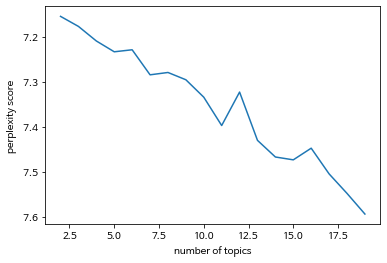

In [92]:
perp_visual(covid_df_corpus, covid_df_dictionary)

In [93]:
ldamodel = gensim.models.ldamodel.LdaModel(covid_df_corpus, num_topics=11, alpha=0.1, id2word = covid_df_dictionary)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, covid_df_corpus, covid_df_dictionary)
vis

2020-08-31 11:07:31,367 : INFO : using symmetric eta at 0.09090909090909091
2020-08-31 11:07:31,369 : INFO : using serial LDA version on this node
2020-08-31 11:07:31,380 : INFO : running online (single-pass) LDA training, 11 topics, 1 passes over the supplied corpus of 417 documents, updating model once every 417 documents, evaluating perplexity every 417 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-31 11:07:31,381 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-08-31 11:07:31,988 : INFO : -9.698 per-word bound, 830.7 perplexity estimate based on a held-out corpus of 417 documents with 44378 words
2020-08-31 11:07:31,989 : INFO : PROGRESS: pass 0, at document #417/417
2020-08-31 11:07:32,434 : INFO : topic #7 (0.100): 0.029*"감염병" + 0.015*"시설" + 0.011*"예방" + 0.009*"수업" + 0.009*"개정" + 0.008*"코로나바이러스" + 0.008*"근거" + 0.008*"투자" + 0.007*"국민" + 0.007*"감염증"
2020-08-31 11:07:

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.105830 -0.034971       1        1  13.757338
5     -0.033267  0.018871       2        1  13.355318
4      0.037859  0.009227       3        1  13.004284
0     -0.008774 -0.034917       4        1  11.624306
10    -0.036520  0.025127       5        1  10.314806
3     -0.076172 -0.017210       6        1   9.325741
2      0.009010 -0.017808       7        1   8.351564
9      0.027260  0.098659       8        1   6.511961
8     -0.011108 -0.023726       9        1   5.309669
6     -0.014610 -0.033024      10        1   4.573666
1      0.000491  0.009772      11        1   3.871355, topic_info=      Term        Freq       Total Category  logprob  loglift
643   벤처기업  198.000000  198.000000  Default  30.0000  30.0000
655     중소  198.000000  198.000000  Default  29.0000  29.0000
153    감염병  531.000000  531.000000  Default  28.0000  28.0000
1086    비대  197.000000  197.000000  Default  27.0000  27.0000
988     수업  137.000000  137.000000  Default  26.0000  26.0000
...    ...         ...         ...      ...      ...      ...
52      확산    6.647716  216.226196  Topic11  -5.5547  -0.2305
177     장관    6.327378  148.800354  Topic11  -5.6040   0.0938
180     정부    6.352382  158.012909  Topic11  -5.6001   0.0377
80      제도    6.362337  193.309082  Topic11  -5.5985  -0.1623
29      상황    6.269181  257.324524  Topic11  -5.6133  -0.4631

[838 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1820      1  0.136548   가계
1820      2  0.045516   가계
1820      4  0.136548   가계
1820      5  0.045516   가계
1820      6  0.455160   가계
...     ...       ...  ...
275       4  0.069507   휴업
275       5  0.347535   휴업
275       6  0.069507   휴업
275       7  0.069507   휴업
275      10  0.069507   휴업

[2853 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 6, 5, 1, 11, 4, 3, 10, 9, 7, 2])